# Problem set 6 starter: Spring 2023

Due: Monday, March 13th at midnight

In [1]:
# Load necessary python libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# For time checks
import time

# Scikit learn models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


# Cross-validation helpers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

# Polynomial generator
from sklearn.preprocessing import PolynomialFeatures

# Set random seed, so our results are similar
# Where does 42 come from?
np.random.seed(42)

# Starter functions

In [2]:
# Function to generate linear data experiments
def genLinData(m,n,R2):
    # y = x_1 + x_2 .. x_n + eps
    # X's scaled so the variance of explained part is 1
    # Function choses variance of noise to set theoretical R2 = R2 argument
    sigNoise = np.sqrt(1./n)
    X = np.random.normal(size=(m,n),loc=0,scale=sigNoise)
    noise = np.sqrt((1.-R2)/R2)
    eps = np.random.normal(size=m,loc=0,scale=noise)
    y = np.sum(X,axis=1)+eps
    return X,y

### A little preprocessing

In [4]:
# Set up initial monte-carlo simulation
X, y = genLinData(60,10,0.75)
Xl, yl = genLinData(2000,10,0.75)

# Expand features(X) using 2-degree polynomials
poly = PolynomialFeatures(degree=2,include_bias=False)
Xpoly = poly.fit_transform(X)
# A reminder of how big Xpoly is (remember it has cross terms like x1*x2, not just x1^2)
# n + n + n(n-1)/2 = 65
print(Xpoly.shape)

# Set up basic simulation parameters
nmc = 1000 # number of randomized cross-validations
testSize = 0.25 # Test set fraction


(60, 65)


### 1. Linear regression

Run a monte-carlo cross-validation for a basic linear regression model using the nmc, and testSize parameters, and cross_Validate() as we usually do.  Report the mean score from both the training and test samples.  Do this for both the (y,X) pair, the (Xl,yl) pair, and the (y,Xpoly) pair. 

In [6]:
# Linear regression
lr = LinearRegression()

# Pair (y,X)
scores = cross_validate(lr, X, y, cv=ShuffleSplit(n_splits=nmc, test_size=testSize), return_train_score=True)
print("Pair (y,X) Mean Train Score: ", np.mean(scores['train_score']))
print("Pair (y,X) Mean Test Score: ", np.mean(scores['test_score']))

Pair (y,X) Mean Train Score:  0.7133886792199724
Pair (y,X) Mean Test Score:  0.4568521898285317


In [7]:
# Pair (Xl,yl)
scores = cross_validate(lr, Xl, yl, cv=ShuffleSplit(n_splits=nmc, test_size=testSize), return_train_score=True)
print("Pair (Xl,yl) Mean Train Score: ", np.mean(scores['train_score']))
print("Pair (Xl,yl) Mean Test Score: ", np.mean(scores['test_score']))


Pair (Xl,yl) Mean Train Score:  0.76167208382098
Pair (Xl,yl) Mean Test Score:  0.7573092641826845


In [8]:
# Pair (y,Xpoly)
scores = cross_validate(lr, Xpoly, y, cv=ShuffleSplit(n_splits=nmc, test_size=testSize), return_train_score=True)
print("Pair (y,Xpoly) Mean Train Score: ", np.mean(scores['train_score']))
print("Pair (y,Xpoly) Mean Test Score: ", np.mean(scores['test_score']))

Pair (y,Xpoly) Mean Train Score:  1.0
Pair (y,Xpoly) Mean Test Score:  -1.1209084034712267


### 2. Ridge regression

Now try a ridge regresion with (y, Xpoly) data only.  Perform a grid search (using a for loop) with alpha in the following range.

np.arange(start=0.1,stop=3.0,step=0.1)

For each alpha find the mean train and test scores (R-squared) from a randomized cross-validation (same params as before).

Plot the test and train mean scores against the alpha values.

Record your bestAlpha from the test data.

Hint: Use
j = np.argmax(testScores)
To get the index for the best alpha value

In [12]:
# Ridge regression
ridge = Ridge()

# Grid search for best alpha
bestAlpha = None
bestScore = -np.inf
alphas = np.arange(start=0.1, stop=3.0, step=0.1)
trainScores = []
testScores = []

for alpha in alphas:
    ridge.set_params(alpha=alpha)
    scores = cross_validate(ridge, Xpoly, y, cv=ShuffleSplit(n_splits=nmc, test_size=testSize), return_train_score=True)
    trainScores.append(np.mean(scores['train_score']))
    testScores.append(np.mean(scores['test_score']))
    if np.mean(scores['test_score']) > bestScore:
        bestAlpha = alpha
        bestScore = np.mean(scores['test_score'])

print("Best Alpha:", bestAlpha)



Best Alpha: 1.2000000000000002


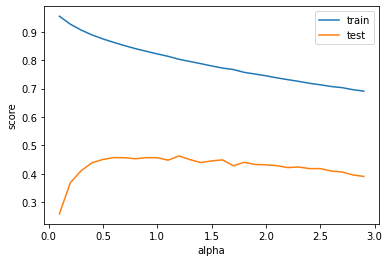

In [13]:
# Plot train and test scores vs alpha
plt.plot(alphas, trainScores, label='train')
plt.plot(alphas, testScores, label='test')
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend()
plt.show()

### 3. Ridge regression summary

Run our usual randomized monte-carlo trial for ridge regression using your bestAlpha value.  Same parameters as before.  Do this with only the (y,Xpoly) pairs and report the mean train and test scores.  Also, report the elapsed time.

In [16]:
# 3. Ridge regression summary

# Run randomized monte-carlo trial for ridge regression with bestAlpha value
start_time = time.time()

ridge = Ridge(alpha=bestAlpha)
cv = ShuffleSplit(n_splits=nmc,test_size=testSize,random_state=42)

train_scores, test_scores = [], []

for i in range(nmc):
    results = cross_validate(ridge, Xpoly, y, cv=cv, return_train_score=True,scoring='r2')
    train_scores.append(np.mean(results['train_score']))
    test_scores.append(np.mean(results['test_score']))
    
mean_train = np.mean(train_scores)
mean_test = np.mean(test_scores)
elapsed_time = time.time() - start_time

print("Ridge regression summary:")
print("Mean train score:", mean_train)
print("Mean test score:", mean_test)
print("Elapsed time:", elapsed_time)


Ridge regression summary:
Mean train score: 0.8043212500778302
Mean test score: 0.4546790515669662
Elapsed time: 648.7305080890656


## 4. Lasso

Repeat question (2) using Lasso.  Use the same parameters except change the alpha range to

for a in np.arange(start=0.00,stop=0.05,step=0.001):


/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected res

/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.770e-03, tolerance: 4.580e-03
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e-02, tolerance: 4.903e-03
  model = cd_fast.enet_coordinate_descent(
/Users/sundayoworah/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

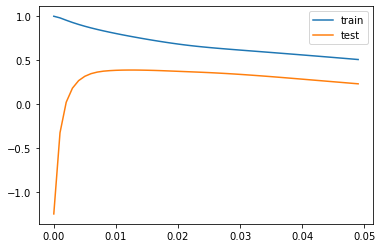

Best alpha: 0.013000000000000001


In [ ]:
# Define alpha range
alphas = np.arange(start=0.00,stop=0.05,step=0.001)

# Perform grid search
train_scores, test_scores = [], []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv = ShuffleSplit(n_splits=nmc,test_size=testSize,random_state=42)
    results = cross_validate(lasso, Xpoly, y, cv=cv, return_train_score=True,scoring='r2')
    train_scores.append(np.mean(results['train_score']))
    test_scores.append(np.mean(results['test_score']))

# Plot test and train mean scores against alpha values
plt.plot(alphas,train_scores,label="train")
plt.plot(alphas,test_scores,label="test")
plt.legend()
plt.show()

# Record bestAlpha from the test data
j = np.argmax(test_scores)
bestAlpha = alphas[j]

print("Best alpha:", bestAlpha)

## 5. Lasso summary

Repeat question (3) using the same parameters and the optimal Lasso alpha from (4).

In [20]:
lasso = Lasso(alpha=bestAlpha)
lasso.fit(Xpoly, y)
train_score = lasso.score(Xpoly, y)
test_score = lasso.score(Xpoly_test, y_test)

print("Lasso summary")
print("Optimal alpha:", bestAlpha)
print("Train R-squared score:", train_score)
print("Test R-squared score:", test_score)



NameError: name 'Xpoly_test' is not defined

## 6. Print zeros

Split the (Xpoly,y) sample into a single train/test split using test_size=0.25.  
Fit a lasso regression to the training sample using the optimal alpha.
Print the lasso coefficients, and the sum of the nonzero coefficients.

## 7. Selective regression

Create a new sample of features corresponding to nonzero coefficients from the lasso regression.
Run a usual monte-carlo cross validation for this using standard least squares regression on this reduced
model.  Report the mean of the train and test scores as usual.

## 8. Robustness

Compare the 3 models (lr,ridge,lasso) on the original data set.  Optimal alpha for each of ridge and lasso here.  Run usual monte-carlo cross validations, reporting mean train and test scores.  All parameters as they have been through the problem set. (nmc and testSize).  Here, you are testing to see how much the ridge and lasso models will hurt you if you are in a minimal overfitting situation, and least squared should be doing ok.

## 9. Discsussion

Compare your results from your various models for the (y,Xpoly) case.  Which model performs best in terms of test R-squared?  What is your overall ranking of models?  (LinearRegression, Ridge, Lasso)

Would Ridge and Lasso have hurt you very much if you were NOT in a serious overfitting situation?  What does this mean for modeling in general, and the usefulness of these approaches?

